In [1]:
import torch
from torch import nn
from PIL import Image
import numpy as np
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as F

import cv2
import os
import matplotlib.pyplot as plt

In [2]:

print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu121
0.18.1+cu121


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.rot90(x, k=-1, dims=[1, 2])),  
    transforms.Lambda(lambda x: torch.flip(x, dims=[2]))  
])

In [4]:
train_data =  datasets.EMNIST(
    root="data",
    split="byclass",
    train=True,
    download=True,
    transform=transform,
    target_transform=None
)   
test_data = datasets.EMNIST(
    root="data",
    split="byclass",
    train=False,
    download=True,
    transform=transform,
    target_transform=None
)


100%|██████████| 561753746/561753746 [00:14<00:00, 38108173.49it/s]


Extracting data\EMNIST\raw\gzip.zip to data\EMNIST\raw


In [5]:
image, label = train_data[465]
image.shape, label

(torch.Size([1, 28, 28]), 42)

In [6]:
image, label = test_data[766]
image.shape, label

(torch.Size([1, 28, 28]), 18)

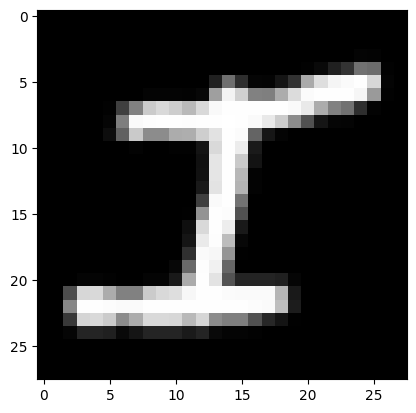

In [7]:
plt.imshow(image.squeeze(),cmap="gray")

In [8]:
random_idx = torch.randint(0, len(train_data), size=[1])
random_idx.item()

631997

In [9]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dl = DataLoader(train_data,
                      batch_size=BATCH_SIZE,
                      shuffle=True)

test_dl = DataLoader(test_data,
                      batch_size=BATCH_SIZE,
                      shuffle=False)
print(f"Dataloaders: {train_dl, test_dl}") 
print(f"Length of train dataloader: {len(train_dl)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dl)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001A3DE8E7650>, <torch.utils.data.dataloader.DataLoader object at 0x000001A3DE8E5F40>)
Length of train dataloader: 21811 batches of 32
Length of test dataloader: 3636 batches of 32


In [10]:
train_featuresbatch, train_labelsbatch = next(iter(train_dl))
train_featuresbatch.shape, train_labelsbatch.shape
class_names = train_data.classes
class_names

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
def accuracy_fn(true,pred):
    correct = torch.eq(true,pred).sum().item()
    acc = (correct/len(pred)) * 100
    return acc

In [13]:
#Timer
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [14]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,
               device:torch.device=device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(true=y, 
                                pred=y_pred.argmax(dim=1)) 
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, 
            "model_loss": loss.item(),
            "model_acc": acc}

In [15]:
def train_model(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               lossfn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):    
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)

        loss = lossfn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(true=y,pred = y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"\nTrain loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%\n")

In [16]:
def test_model(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               lossfn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    test_loss,test_acc = 0,0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            
            test_loss += lossfn(test_pred, y)
            test_acc += accuracy_fn(true=y, 
                                pred=test_pred.argmax(dim=1)) 
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
    print(f"\nTest loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [17]:
#Model
class EMNISTV0(nn.Module):
    def __init__(self, input_shape:int, hidden_units: int, output_shape:int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x

In [18]:
torch.manual_seed(42)
model = EMNISTV0(input_shape=1,
                        hidden_units=32,
                        output_shape=len(class_names)).to(device)
model

EMNISTV0(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=62, bias=True)
  )
)

In [19]:
from pathlib import Path
ModelPath = Path("models")
ModelPath.mkdir(parents= True,exist_ok= True)

ModelName = "EMNISTV1.pth"
ModelSavePath = ModelPath / ModelName   
ModelSavePath

WindowsPath('models/EMNISTV1.pth')

In [20]:
model.load_state_dict(torch.load(ModelSavePath))

<All keys matched successfully>

In [54]:
images = torch.rand(size=[32,3,64,64])
images.shape

torch.Size([32, 3, 64, 64])

In [55]:
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=1)

conv_layer(images[0].unsqueeze(dim=0)).shape

torch.Size([1, 10, 64, 64])

In [21]:
lossfn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                        lr = 0.1)
from tqdm.auto import tqdm

In [57]:
torch.manual_seed(42)
traintime_startmodel2 = timer()

epochs = 20

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    train_model(model=model,
                data_loader=train_dl,
                lossfn=lossfn,
                optimizer=optimizer,
                accuracy_fn=accuracy_fn,
                device="cuda")
    test_model(model=model,
                data_loader=test_dl,
                lossfn=lossfn,
                accuracy_fn=accuracy_fn,
                device="cuda")
traintime_endmodel2 = timer()
print_train_time(start=traintime_startmodel2,
                 end=traintime_endmodel2,
                 device = "cuda")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
-----

Train loss: 0.51220 | Train acc: 82.78%


Test loss: 0.42559 | Test acc: 84.51%

Epoch: 1
-----

Train loss: 0.39888 | Train acc: 85.57%


Test loss: 0.39840 | Test acc: 85.36%

Epoch: 2
-----

Train loss: 0.37889 | Train acc: 86.16%


Test loss: 0.38779 | Test acc: 86.20%

Epoch: 3
-----

Train loss: 0.36787 | Train acc: 86.46%


Test loss: 0.37635 | Test acc: 86.37%

Epoch: 4
-----

Train loss: 0.35996 | Train acc: 86.74%


Test loss: 0.37485 | Test acc: 86.30%

Epoch: 5
-----

Train loss: 0.35445 | Train acc: 86.88%


Test loss: 0.37100 | Test acc: 86.20%

Epoch: 6
-----

Train loss: 0.34975 | Train acc: 86.98%


Test loss: 0.37556 | Test acc: 86.16%

Epoch: 7
-----

Train loss: 0.34575 | Train acc: 87.11%


Test loss: 0.37075 | Test acc: 86.37%

Epoch: 8
-----

Train loss: 0.34203 | Train acc: 87.23%


Test loss: 0.37036 | Test acc: 86.55%

Epoch: 9
-----

Train loss: 0.33945 | Train acc: 87.29%


Test loss: 0.36831 | Test acc: 86.58%

Epoch: 10
-----

Train loss: 0

2517.931066600009

In [22]:
model_results = eval_model(model=model,
                              data_loader=test_dl,
                              loss_fn=lossfn,
                              accuracy_fn=accuracy_fn,
                              device="cuda")


In [23]:
model_results["model_acc"]

86.62191740007334

In [25]:
import pandas as pd
compare_results = pd.DataFrame([model_results])
compare_results

,model_name,model_loss,model_acc
0,EMNISTV0,0.368208,86.621917


In [25]:
def make_predictions(model:torch.nn.Module,
                     data:list,
                     device:torch.device="cuda"):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample,dim=0).to(device)
            pred_logits = model(sample)
            pred_prob = torch.softmax(pred_logits.squeeze(),dim=0)
            pred_probs.append(pred_prob.cuda())

    return torch.stack(pred_probs)

In [23]:
import random
random.seed(64)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 3 (3)


In [24]:
pred_probs= make_predictions(model=model, 
                             data=test_samples)
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([ 3,  1, 49,  3,  1, 36, 53, 23, 55], device='cuda:0')

In [25]:
test_labels, pred_classes

([3, 47, 49, 3, 1, 36, 53, 23, 55],
 tensor([ 3,  1, 49,  3,  1, 36, 53, 23, 55], device='cuda:0'))

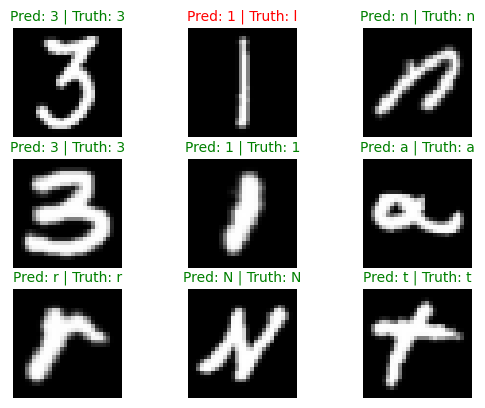

In [26]:
plt.figure()
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]] 
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") 
    else:
        plt.title(title_text, fontsize=10, c="r") 
    plt.axis(False)

In [31]:
torch.save(obj=model.state_dict(),f = ModelSavePath)

In [ ]:
from collections import defaultdict
import re
image_dir = 'preprocessed/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform2 = transforms.Compose([
    transforms.ToTensor(),  
])

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
word_groups = defaultdict(list)

for filename in image_files:
    match = re.match(r"(text\d+)_(\d+)\.png", filename)
    if match:
        word_id, letter_idx = match.groups()
        word_groups[word_id].append((int(letter_idx), filename))

full_phrase = []
for word_id in sorted(word_groups.keys(), key=lambda x: int(x[4:])):  #sort words by number
    sorted_files = [fname for _, fname in sorted(word_groups[word_id])]
    img_tensors = []

    for filename in sorted_files:
        img_path = os.path.join(image_dir, filename)
        preprocessed_img = cv2.imread(img_path)

        if preprocessed_img is None:
            print(f"Warning: {filename} couldn't be read.")
            continue

        image = cv2.cvtColor(preprocessed_img, cv2.COLOR_BGR2GRAY)
        image = 255 - image
        resized = cv2.resize(image, (28, 28), interpolation=cv2.INTER_AREA)

        for x in range(28):
            for y in range(28):
                if resized[x][y] < 105:
                    resized[x][y] = 0

        resized = resized / 255.0
        img_tensor = transform2(resized).to(torch.float32)
        img_tensors.append(img_tensor)

    if not img_tensors:
        continue

    batch_tensor = torch.stack(img_tensors).to(device)

    with torch.no_grad():
        pred_probs = make_predictions(model, data=batch_tensor)
        pred_classes = pred_probs.argmax(dim=1)

    predicted_letters = [class_names[i] for i in pred_classes]
    predicted_word = ''.join(predicted_letters)
    full_phrase.append(predicted_word)

final_output = ' '.join(full_phrase)
print(f"Predicted phrase: {final_output}")

Predicted phrase: HELL0 W0RLD
